# Homework 1
Nathan LeRoy

## Problem 1
To begin this problem, we need to create a function to represent this model in python:

$\dfrac{dN}{dt} = RN(1-\dfrac{N}{C}) - \dfrac{rN^{2}}{N_{c}^{2} + N^{2}}$

In [1]:
# import libraries
import numpy as np

In [2]:
def dNdt(_, N: list[float] , R: float, C: float, r: float, Nc: float) -> list[float]:
    """
    Mosquito population model.
    
    N - array-like - array with one value to represent number of mosquitos
    R - float - intrinsic growth rate
    C - float - carrying capacity
    Nc - float - critical size
    r - float - maximum growth rate
    """ 
    return [(R*N[0]*(1-(N[0]/C))) - (r*N[0]**2/(Nc**2 + N[0]**2))]

SciPy provides a nice simple interface to integrate functions using runge-kutta:

In [3]:
# import runge-kutta integrator
from scipy.integrate import solve_ivp

# conditions
t0 = 0 # days
tf = 50 # days
N_0 = 10000 # skeeters

# constants
R = 0.55 # 1/days
C = 1e4
Nc = 1e4
r = 1e4 # skeeters per day

# solve the model
res_1 = solve_ivp(
    dNdt, 
    t_span=[t0, tf], 
    y0=[N_0],
    method="RK45",
    args=(R, C, r, Nc),
    max_step=0.01 # force a smooth graph
)

# redefine parameters
R = 0.55 # 1/days
C = 1e10
Nc = 1e4
r = 1e4 # skeeters per day

res_2 = solve_ivp(
    dNdt, 
    t_span=[t0, tf], 
    y0=[N_0],
    method="RK45",
    args=(R, C, r, Nc),
    max_step=0.01 # force a smooth graph
)

Lets investigate the results

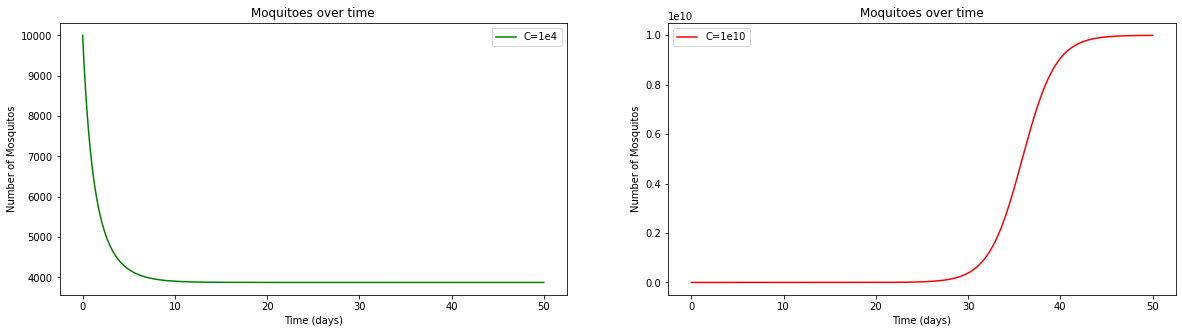

In [4]:
import matplotlib.pyplot as plt

# create a figure
fig, ax = plt.subplots(1,2, figsize=(20,5))

# plot result 1
ax[0].plot(res_1.t, res_1.y[:][0], 'g-')
ax[0].set_title("Moquitoes over time")
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Number of Mosquitos")
ax[0].legend(['C=1e4'])

# plot result 2
ax[1].plot(res_2.t, res_2.y[:][0], 'r-')
ax[1].set_title("Moquitoes over time")
ax[1].set_xlabel("Time (days)")
ax[1].set_ylabel("Number of Mosquitos")
ax[1].legend(['C=1e10'])

# display
plt.show()

## Problem 2
Modeling the this system of erythropoiesis will take some cleverness. I don't want to hardcode 10 equations... so I am going ot try to make this dyanmic and all you need to do is give a value for $N$ and then some rate constants.

We will always have $N+1$ equations in the system. We can assume that the number of cells in each compartment is equal to zero initially. For this problem our rate constants will be all the same, but it could be cool to make it so that thye could theorhetically be different.

Besides equation $1$ and the blood equation, all equations take on the form:

$\dfrac{dX_{i}}{dt} = 2kX_{i-1}X_{i-1} - k_{i}X{i}$

So the first equation will need to be hardcoded and the blood equation will need to be hardcoded in our system function, Otherwise, we can loop through to run these calcs.

In [25]:
def cell_system(_, X: list[float], k: list[float], I: float, D: float = 200e9):
    """
    Function to model the erythropoiesis system.
    
    X - array of floats - each representing the amount of cells in compartment i
    k - array of floats - each one corresponding to the ith compartments loss/gen rate
    I - float - number of cells committed to erythropoiesis per day
    P - float - production of blood cells per day 
    """
    # initially check for negatives
    # as we cant have negative amounts
    # of cells
    for i in range(len(X)):
        if X[i] <= 0:
            X[i] = 0
    
    # init array to return
    dXdt = np.zeros(len(X))
    
    # set value of first equation dX1/dt
    dXdt[0] = I - k[0]*X[0]
    
    # iterate through the next N-1 equations
    for i in range(1,len(X)-1):
        dXdt[i] = 2*k[i-1]*X[i-1] - k[i]*X[i]
    
    # run the final equation for blood
    # by leveraging the i value in the
    # for loop
    i +=1
    dXdt[i] = 2*k[i-1]*X[i-1] - D
    
    return dXdt

### Problem setup in code
To keep the problem dynamic, I'll set the number of compartments to model ($N$) and then build up the problem from there. We need `X_0` to have a length of $N+1$ to model $N$ compartments **as well as blood**.

The value of `k` needs to be an array of length $N$. I found that a time span of 0 $\rightarrow$ 5 days was sufficient. This does depend on the value of $I$, however, and I really just arbitratily was checking some values there.

In [26]:
# define number of compartments
N = 10

# set up initial system
X_0 = np.zeros(N+1)
t0 = 0 # days
tf = 15 # days
k = 2.2 * np.ones(N) # array of constant k values

# committed cells
I = 200e9/(2**(N-2)) # cells per day

# run the solver
res = solve_ivp(
    cell_system,
    t_span=[t0, tf],
    y0 = X_0,
    method='RK45',
    args=(k,I),
    max_step=0.01 # for smoothness of plots
)


Text(0, 0.5, 'Billions of cells')

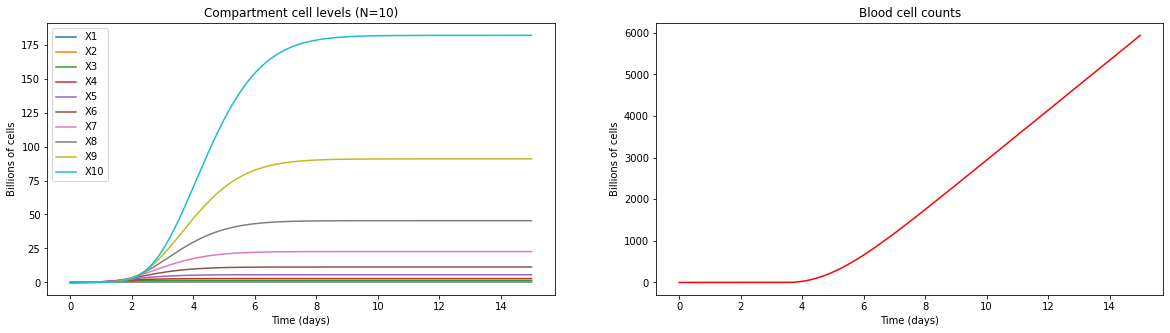

In [27]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# plot compartment values
for i in range(N):
    ax[0].plot(res.t, res.y[i]/1e9)

# style
ax[0].legend([f"X{i+1}" for i in range(N)])
ax[0].set_title(f"Compartment cell levels (N={N})")
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Billions of cells")

# plot blood value
ax[1].plot(res.t, res.y[N]/1e9, 'r-')
ax[1].set_title(f"Blood cell counts")
ax[1].set_xlabel("Time (days)")
ax[1].set_ylabel("Billions of cells")

Based on my analytical calculations, we know that the steady-state value for any compartment, $i$ is found to be:

$$X_{i_{ss}} = \dfrac{2^{i-1}I}{k_{i}}$$

Thus, if we take the ratio of neighboring compartment steady-state values, they should have a ratio almost exactly equal to 2

In [8]:
# check steady-state ratios
for i in range(N-1):
    print(f"ratio found: {round(res.y[i+1][-1]/res.y[i][-1],2)}")

ratio found: 2.0
ratio found: 2.0
ratio found: 2.0
ratio found: 2.0
ratio found: 2.0
ratio found: 2.0
ratio found: 2.0
ratio found: 2.0
ratio found: 2.0


In [24]:
print(f"X1 = {round(res.y[0][-1])}")
print(f"I/k1 = {round(I/k[0])}")

X1 = 355113636
I/k1 = 355113636


We also know from the analytical solutions of these equations that the critical ratio of our death rate to introduction rate is:

$$
\dfrac{D}{I} = 2^{N}
$$

So, lets examine some slution sets below, at and above this critical ratio:

In [13]:
# define number of compartments
N = 10

# set up initial system
X_0 = np.zeros(N+1)
t0 = 0 # days
tf = 15 # days
k = 2.2 * np.ones(N) # array of constant k values

D = 200e9 # death rate

# committed cells
I_below = D/(2**(N+2)) # cells per day
I_at = D/(2**N) + 1000 # cells per day
I_above = D/(2**(N-2)) # cells per day

# run the solver for below
res_below = solve_ivp(
    cell_system,
    t_span=[t0, tf],
    y0 = X_0,
    method='RK45',
    args=(k, I_below, D),
    max_step=0.01 # for smoothness of plots
)

# run the solver for at
res_at = solve_ivp(
    cell_system,
    t_span=[t0, tf],
    y0 = X_0,
    method='RK45',
    args=(k, I_at),
    max_step=0.01 # for smoothness of plots
)

# run the solver for above
res_above = solve_ivp(
    cell_system,
    t_span=[t0, tf],
    y0 = X_0,
    method='RK45',
    args=(k, I_above),
    max_step=0.01 # for smoothness of plots
)


...and plot

Text(0, 0.5, 'Billions of cells')

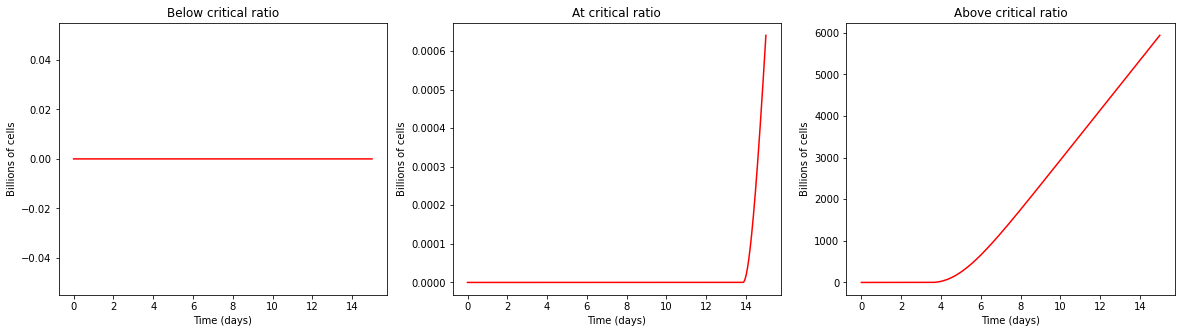

In [14]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

# plot blood value below ratio
ax[0].plot(res_below.t, res_below.y[N]/1e9, 'r-')
ax[0].set_title(f"Below critical ratio")
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Billions of cells")

# plot blood value at ratio
ax[1].plot(res_at.t, res_at.y[N]/1e9, 'r-')
ax[1].set_title(f"At critical ratio")
ax[1].set_xlabel("Time (days)")
ax[1].set_ylabel("Billions of cells")

# plot blood value at below ratio
ax[2].plot(res_above.t, res_above.y[N]/1e9, 'r-')
ax[2].set_title(f"Above critical ratio")
ax[2].set_xlabel("Time (days)")
ax[2].set_ylabel("Billions of cells")